In [276]:
import psycopg2
import pandas.io.sql as psql
import pandas as pd
from matplotlib import pyplot as plt
from __future__ import division #now division always returns a floating point number
import numpy as np
import seaborn as sns
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from collections import namedtuple
%matplotlib inline

In [290]:
def rmean_sq(y_true, y_pred):
    rmse = namedtuple('rmse', ['rmse', 'array'])
    sq_error = []
    assert len(y_true) == len(y_pred)
    for i in range(len(y_true)):
        sq_error.append((y_true[i] - y_pred[i])**2)
    return rmse(np.sqrt(np.mean(sq_error)), np.sqrt(sq_error))


def run_tests(model, X, y, n):
    all_me = []
    all_espn = []
    MSE = namedtuple('MSE', ['me', 'espn', 'n'])
    for i in range(n):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
        model.fit(X_train, y_train)
        model_predicted_points = model.predict(X_test)
        me = rmean_sq(y_test, model_predicted_points)
        espn = rmean_sq(y_test, X_test.points_projected)
        all_me.append(me)
        all_espn.append(espn)
    return MSE(all_me, all_espn, n)

# NEED TO COMPLETELY REDO WITH JUST WEEK 1 & 2 projection data and the actual points outcome and then use week 3 projection data as the test

In [319]:
season = 2015
week = 3
db = psycopg2.connect("dbname='fantasyfootball' host='localhost'")

projected_points = psql.read_sql("""
    select name, team, position, week, total_points as points_projected
    from next_week_projections
    where season = {0} and (week = '{1}' or week = '{2}')""".format(season, week, week-1), con=db)
projected_points['index'] = projected_points['name'] + "_" + projected_points['team'] + "_" + projected_points['week']
projected_points = projected_points.set_index('index')
del projected_points['name']
del projected_points['team']
del projected_points['position']
del projected_points['week']

last_week_data = psql.read_sql("""
    select *
    from scoring_leaders_weekly
    where season = {0} and (week = '{1}' or week = '{2}')""".format(season,week-1, week), con=db)
last_week_data['index'] = last_week_data['name'] + "_" + last_week_data['team'] + "_" + last_week_data['week']
last_week_data = last_week_data.set_index('index')

last_week_data.drop(['name', 'season'], axis=1, inplace=True)

In [320]:
merged_data = projected_points.merge(last_week_data, how='right', left_index=True, right_index=True)
merged_data = merged_data.dropna()

le = preprocessing.LabelEncoder()
merged_data['team_factor'] = le.fit_transform(merged_data.team)
merged_data['position_factor'] = le.fit_transform(merged_data.position)
merged_data['opponent_factor'] = le.fit_transform(merged_data.opponent)

merged_data.drop(['team', 'position', 'opponent'], axis=1, inplace=True)

X_train = merged_data[merged_data.week == '2']
X_test = merged_data[merged_data.week == '3']

y_train = X_train['total_points']
y_test = X_test['total_points']

del X_train['total_points']
del X_test['total_points']

clf = RandomForestClassifier(n_estimators=1000)

In [329]:
clf.fit(X_train, y_train)
model_predicted_points = clf.predict(X_test)
me = rmean_sq(y_test, model_predicted_points)
espn = rmean_sq(y_test, X_test.points_projected)

In [330]:
me.rmse

4.8551843975260693

In [331]:
espn.rmse

6.4039732812065795

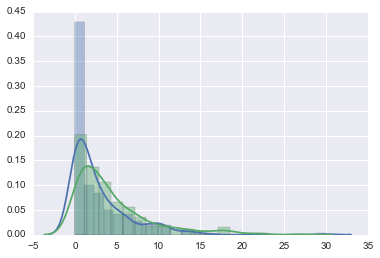

In [332]:
sns.distplot(me.array)
sns.distplot(espn.array)

# MY Team

In [334]:
players = y_test.index.values.tolist()
cj_index = players.index('C.J. Anderson_Den_3')
model_predicted_points[cj_index]

2

In [335]:
X_test.iloc[cj_index,:]

points_projected        12.9
week                       3
passing_completed          0
passing_attempted          0
passing_yds                0
passing_td                 0
passing_int                0
rushing_attempts           8
rushing_yds               18
rushing_td                 0
receiving_receptions       1
receiving_yds              9
receiving_td               0
receiving_targets          1
two_point_conv             0
fumbles                    0
total_returned_tds         0
won_game                   1
team_score                24
opponent_score            12
at_home                    0
team_factor               20
position_factor            3
opponent_factor           10
Name: C.J. Anderson_Den_3, dtype: object